# inner edge of stability
generates populations of 3 planet systems with spock to determine if simulations follow the observed pattern of there being less planets with compact period ratios

In [288]:
#Variables to play with, eventually will be deprecated:
bin_number = 30

In [289]:
#Import Statements & Define Constants
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.stats as stats
from scipy.stats import lognorm
from scipy.stats import ks_2samp
import math
import rebound
import random
from numpy.random import seed, random
from scipy.stats import rayleigh
from scipy.stats import norm
import itertools
from spock import FeatureClassifier
from decimal import Decimal
import pandas as pd
from tqdm import tqdm
from matplotlib.ticker import EngFormatter
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
import seaborn as sns


%matplotlib inline

fmodel = FeatureClassifier()
earth_mass = 5.97219*10**24
sun_mass = 1.981 * 10**30
mass_ratio = earth_mass/sun_mass

[02:52:26] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:888: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.


# NASA Exoplanet Archive
Use archive to find planets that have compact period ratios and to determine densities for orbital parameters

In [339]:
#Nikolas's Work!
#MAKE INITIAL DATA FRAME

# try:
#     planet_data = pd.read_csv('planet_data.csv', index_col=0)
# except:
df = pd.read_csv('20230302_all_exoplanets.csv')
    # Create an array of all host star/system names
hosts = df['hostname'].unique()
# For each planetary system...
for host in tqdm(hosts):
    # If the system contains less than 3 planets...
    if (df['hostname'] == host).sum() < 3:
        # Get the row indices of the system's planets
        index = df[df['hostname']==host].index
        # Remove those rows from our DataFrame
        df.drop(index, inplace=True)
many_p_hosts = df['hostname'].unique()
#Calculates all_p_ratios
# planets dictionary – keys are planet names, values are Booleans
# Value = True if this planet is a member of a pair with P-ratio <= 1.5, False otherwise
planets = {}
# List of all period ratios less than or equal to 1.5
all_p_ratios = []
for host in many_p_hosts:
    # Create a Data Frame of only this system's planets
    system_df = df[df['hostname'] == host]
    # system — a list of tuples of the form (period, planet_name)
    system = []
    # Populate system, add to planets
    for ind in system_df.index:
        system += [(system_df['pl_orbper'][ind], system_df['pl_name'][ind])]
        # Planet values are False by default
        planets[system_df['pl_name'][ind]] = False
    # Sort the system from smallest period to largest
    system.sort()

# Data that might be useful to us
planet_data = pd.DataFrame()
planet_data["Planet Name"] = df['pl_name']
planet_data["Host Name"] = df['hostname']
planet_data["Orbital Period"] = df['pl_orbper']
planet_data["Discovery Method"] = df['discoverymethod']
planet_data["Semi-Major Axis (AU)"] = df['pl_orbsmax']
planet_data["Eccentricity"] = df['pl_orbeccen']
planet_data["Radius (R_earth)"] = df['pl_rade']
planet_data["Mass or Mass * sin(i) (M_earth)"] = df['pl_bmasse']
planet_data["Stellar Mass (M_sun)"] = df['st_mass']
planet_data.to_csv('planet_data.csv')
df = pd.read_csv('planet_data.csv', index_col=0)
df.head()

100%|█████████████████████████████████████████████████████| 3943/3943 [00:08<00:00, 473.41it/s]


,Planet Name,Host Name,Orbital Period,Discovery Method,Semi-Major Axis (AU),Eccentricity,Radius (R_earth),Mass or Mass * sin(i) (M_earth),Stellar Mass (M_sun)
17,2MASS J19383260+4603591 b,2MASS J19383260+4603591,406.0000,Eclipse Timing Variations,0.9200,0.330,13.4,603.8770,0.48
22,47 UMa b,47 UMa,1078.0000,Radial Velocity,2.1000,0.032,13.2,804.0800,1.06
23,47 UMa c,47 UMa,2391.0000,Radial Velocity,3.6000,0.098,14.2,171.6210,1.06
24,47 UMa d,47 UMa,14002.0000,Radial Velocity,11.6000,0.160,13.5,521.2200,1.06
27,55 Cnc b,55 Cnc,14.6516,Radial Velocity,0.1134,0.000,13.9,263.9785,0.91


In [340]:
# GET RID OF ONES THAT DON'T HAVE INNER PRATIO 1.1-1.5
df['Keep'] = False
for system in df['Host Name'].unique():
    system_df = df[df['Host Name'] == system]
    system_sorted = system_df.sort_values(by='Orbital Period')
    Nplanets = system_df.shape[0] # number of planets in system
    Ntrios = Nplanets - 2 # number of trios
    
    for q in range(Ntrios):
        P1 = system_sorted.iloc[q]['Orbital Period']
        P2 = system_sorted.iloc[q+1]['Orbital Period']
        P3 = system_sorted.iloc[q+2]['Orbital Period']
#         print(P1, P2, P3)
        if P2/P1 > 1.1 and P2/P1 < 1.5:
            df.loc[system_sorted.iloc[q].name, 'Keep'] = True
            df.loc[system_sorted.iloc[q+1].name, 'Keep'] = True
            df.loc[system_sorted.iloc[q+2].name, 'Keep'] = True
            

In [341]:
# NEW DF
compact_df = df[df['Keep'] == True]
len(compact_df)
compact_df.to_csv('compact_planet_data.csv')
df = pd.read_csv('compact_planet_data.csv', index_col=0)
df.head()

,Planet Name,Host Name,Orbital Period,Discovery Method,Semi-Major Axis (AU),Eccentricity,Radius (R_earth),Mass or Mass * sin(i) (M_earth),Stellar Mass (M_sun),Keep
119,DMPP-1 b,DMPP-1,18.570,Radial Velocity,0.1462,0.083,5.29,24.27,1.21,True
120,DMPP-1 c,DMPP-1,6.584,Radial Velocity,0.0733,0.057,3.06,9.60,1.21,True
122,DMPP-1 e,DMPP-1,5.516,Radial Velocity,0.0651,0.070,1.86,4.13,1.21,True
194,GJ 180 b,GJ 180,17.133,Radial Velocity,0.0920,0.070,2.43,6.49,0.43,True
195,GJ 180 c,GJ 180,24.329,Radial Velocity,0.1290,0.090,2.41,6.40,0.43,True


In [349]:
# save compact pratios 
pratios_observed = []
for system in df['Host Name'].unique():
    system_df = df[df['Host Name'] == system]
    system_sorted = system_df.sort_values(by='Orbital Period')
    Nplanets = system_df.shape[0] # number of planets in system
    for z in range(Nplanets-1):
        P1 = system_sorted.iloc[z]['Orbital Period']
        P2 = system_sorted.iloc[z+1]['Orbital Period']
        if P2/P1 > 1.1 and P2/P1 < 1.5:
            pratios_observed.append(P2/P1)

In [293]:
# check that the lengths match, they do :)
trios = get_trios(Plist = plist)
flattened_list = [item for sublist in trios for item in sublist]

# Find unique values
unique_values = set(flattened_list)

# Get the count of unique values
count_unique_values = len(unique_values)

print(f"There are {count_unique_values} unique values")

There are 161 unique values


# set up for dispersion

In [294]:
plist = [] # master plist, where each entry will be [P1,P2,..., PN] for each sim
for system in df['Host Name'].unique():
    periods = df[df['Host Name']==system]['Orbital Period'].values
    periods.sort()
    plist.append(periods)
plist
# populate trios with get_trios from rori code, drop the ones where the inner is not less than 1.5

[array([ 5.516,  6.584, 18.57 ]),
 array([ 17.133,  24.329, 106.3  ]),
 array([28.14 , 39.026, 62.24 ]),
 array([14.175685, 19.590025, 29.54115 ]),
 array([ 28.579743,  38.353037, 101.12    ]),
 array([ 5.75999,  7.28243, 10.86499, 25.1967 ]),
 array([12.1621839, 17.667087 , 29.79749  ]),
 array([ 5.24 ,  7.775, 10.115]),
 array([4.528598, 6.131243, 9.327527]),
 array([ 7.138048, 10.45582 , 14.76289 ]),
 array([ 4.44117,  6.42904, 14.09189]),
 array([ 6.679582,  9.715043, 13.62749 ]),
 array([ 5.577212,  7.760178, 15.189034]),
 array([0.2197 , 0.32528, 0.81161]),
 array([  7.008151,   8.719375,  14.44912 ,  91.93913 , 124.9144  ,
        210.60697 ]),
 array([ 5.28696,  7.07142, 10.3117 , 16.1457 ]),
 array([ 10.3039,  13.0241,  22.6845,  31.9996,  46.6888, 118.3807]),
 array([3.26663995, 4.27225018, 5.45298175]),
 array([10.3134, 13.7815, 23.0923]),
 array([2.89223021, 3.95116882, 5.10115756, 5.99273738]),
 array([ 6.195469,  8.348125, 13.767102]),
 array([ 7.466623, 11.131786, 16.259

In [295]:
# rori function
def p_ratios(P=None, logP=None, sim=None, log=True):
    """returns either the log or the normal period ratios of a system
       Param: a list of periods, log a, a, or a rebound sim
    """
    if logP != None:
        logpr = [logP[i+1]-logP[i] for i in range(len(logP)-1)]
        if log:
            return logpr
        else:
            return [10**x for x in logpr]
    if sim != None:
        ps = sim.particles[1:]
        P = [ps[i].P for i in range(len(ps))]   

    if log:
        return [np.log10(P[i+1]/P[i]) for i in range(len(P)-1)]
    else:
        return [P[i+1]/P[i] for i in range(len(P)-1)]
    
def get_trios(Plist=None, P=None, filter4=False, stable=None):
    """returns a tuple containing all the trios of adjacent planets 
        in population (lol of periods) of systems.
       optional param: stable: a list of booleans corresponding to
        the stability of each system. Returns the corresponding stability 
        of each trio
    """
    trios = []
    s = []
    
    if P!=None:
        Plist = [P]
        
    if len(Plist)==0:
        return []
    
    for i in range(len(Plist)):
        P = Plist[i]
        pr = p_ratios(P=P, log=False)
        for j in range(0, len(pr)-1):
            if P[j+1]/P[j]<1.5 and P[j+1]/P[j]>1.1:
                trios += [P[j:j+3]]
                if stable != None:
                    s += [stable[i]]

    if stable!=None:
        return s
    return trios


In [296]:
trios = get_trios(Plist = plist)
len(trios)

58

## Dispersion

$\sigma= \sqrt{\frac{1}{2}\sum_{j=1}^{2}{{(s_{j-1, j}-\overline{s})^2}}}$

Dispersion of the ith trio
$D_i = \frac{\sigma_{i}}{\overline{s}_i}$

Average dispersion $D = \sqrt{\frac{1}{N_{\mathrm{trios}}}\sum_{i=1}^{N_{\mathrm{trios}}}D_i^2}$

sj is log of period ratio

In [297]:
import pandas as pd
from matplotlib.ticker import ScalarFormatter, NullFormatter
import matplotlib.pyplot as plt
import numpy as np
from numpy import random
from scipy.stats import pearsonr
from scipy.stats import linregress
import rebound
from IPython.display import display, clear_output

from spock import FeatureClassifier
model = FeatureClassifier()


#from ipynb.fs.full.functions import *

[02:52:59] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:888: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.


In [298]:
def dispersion(trios=None, systems=None, filter4=False, ddof=1): # input systems: orbital periods
    """returns the dispersion and error of a list of 
       trios as a tuple.
       For a single trio, only returns the dispersion
    """
    if systems != None:
        trios = get_trios(systems, filter4=filter4)
    
    if len(trios)==0:
        return 0, 0
    
    rel_var = []
    for t in trios:
        logpr = p_ratios(P=t, log=True)
        mu = np.mean(logpr)
        rel_var += [np.var(logpr)/mu**2]
    D = np.sqrt(np.mean(rel_var))
    if len(trios)>1: 
        error = 1/(2*D)*np.std(rel_var, ddof=ddof)/np.sqrt(len(trios))
    else:
        error = 10
    return D, error

In [299]:
stdev = dispersion(trios=get_trios(Plist = plist))
stdev

(0.3024495566800291, 0.029768249999932016)

In [336]:
def simulate_trios(D):
    p1period = 1
    p2period = np.random.uniform(1.1,1.5)
    p3period = 0
    while p3period < p2period:
        s12= math.log10(p2period/p1period) 
        s23= np.random.normal(np.log10(1.3),D*np.log10(1.3))
        print(s12, D*s12, s23)
        p3period = p2period*10**s23
    return [p1period,p2period,p3period]


trioslist=[simulate_trios(.302449556680029) for i in range(0,1000)]

0.1612029620278419 0.04875576440082833 0.14808635839082046
0.10348919391290651 0.031300260820132125 0.1583705864708403
0.05569968047196512 0.01684634366596512 0.11485356196491213
0.08222906052454279 0.024870142901863238 0.14722452497776675
0.1627541513426285 0.049224920921412334 0.11218167665164272
0.1539826365200329 0.046571980151905994 0.09673342775937914
0.11612080913162466 0.03512068724318614 0.0730543803189996
0.07167363924026096 0.021677660413861256 0.09011058627504837
0.05471531537075107 0.016548622877491637 0.14275223882439375
0.1601123660452049 0.04842591412936275 0.1134649455801541
0.10988091952982379 0.033233435399389145 0.13854717858640248
0.107999520617566 0.03266440713243849 0.09082133002109333
0.07530615858535504 0.02277631427941659 0.14573074710511516
0.09893087999006331 0.0299216007949598 0.17885203088291507
0.06315499944880398 0.01910120158541824 0.11432719739824275
0.05141881657439165 0.015551598277936481 0.11959764090660742
0.07014821021726968 0.021216295082110693 0

In [337]:
np.random.normal(.11,.3*.11)

0.08584841129065729

In [338]:
dispersion(trios=trioslist)

(0.24428129211852947, 0.005066601607689658)

# done dispersion

<class 'numpy.ndarray'>


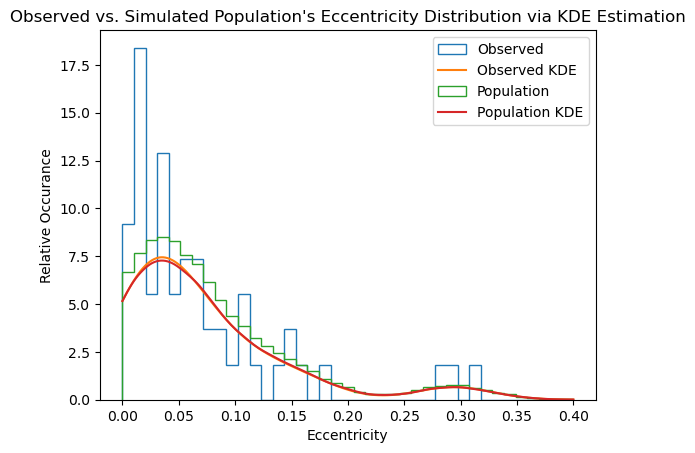

In [300]:
#eccentricities after spock
# Initialize the population eccentricites from observered eccentricities: e_list
# Load the data
eccentricity = df['Eccentricity'].to_numpy()

# Remove NaN and infinite values from the array
eccentricity = eccentricity[~np.isnan(eccentricity)]
eccentricity = eccentricity[eccentricity != 0]
eccentricity = eccentricity[np.isfinite(eccentricity)]

# Fit a KDE to the data
kde_e = gaussian_kde(eccentricity)

# Generate 10000 samples from the KDE
e_list = kde_e.resample(size=150000)[0] #change eccentricity to be half of kde see how much change

print(type(e_list))


# Create a histogram of the original data
n, bins_e, patches = plt.hist(eccentricity, bins=np.linspace(0, 0.4, 40), histtype='step', density=True, label = 'Observed')

# Plot the kernel density curve of the original data
x_grid_e = np.linspace(0, 0.4, 200)
plt.plot(x_grid_e, kde_e(x_grid_e), label='Observed KDE')

# Create a histogram of the new samples
n_new, bins_new, patches_new = plt.hist(e_list, bins=bins_e, histtype='step', density=True, label = 'Population')

# Plot the kernel density curve of the new samples
kde_new_e = gaussian_kde(e_list)
plt.plot(x_grid_e, kde_new_e(x_grid_e), label='Population KDE')
e_list = e_list[e_list > 0]

# Set plot title, labels, and legend
plt.title("Observed vs. Simulated Population's Eccentricity Distribution via KDE Estimation")
plt.xlabel("Eccentricity")
plt.ylabel("Relative Occurance")
plt.legend()

# Show the plot
plt.show()


<class 'numpy.ndarray'>


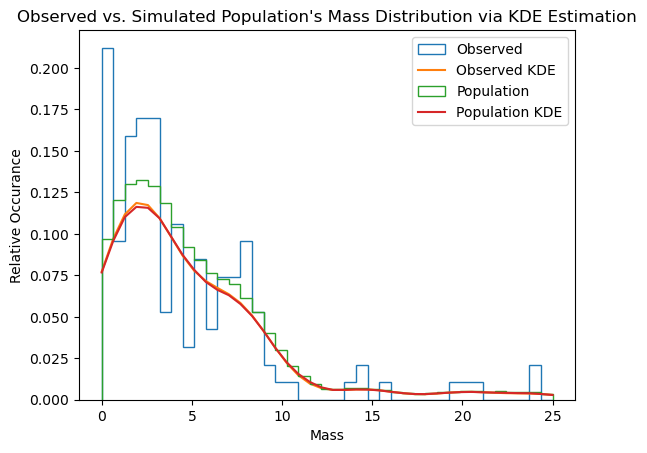

In [301]:
#masses after spock

# Initialize the population masses from observered masses: m_list
# Load the data
mass = df['Mass or Mass * sin(i) (M_earth)'].to_numpy()

# Remove NaN and infinite values from the array
mass = mass[~np.isnan(mass)]
mass = mass[mass != 0]
mass = mass[np.isfinite(mass)]
mass = mass[mass < 25]

# Fit a KDE to the data
kde = gaussian_kde(mass)

# Generate 10000 samples from the KDE
m_list = kde.resample(size=150000)[0]
print(type(m_list))


# Create a histogram of the original data
n, bins, patches = plt.hist(mass, bins=np.linspace(0, 25, 40), histtype='step', density=True, label = 'Observed')

# Plot the kernel density curve of the original data
x_grid = np.linspace(0, 25, 40)
plt.plot(x_grid, kde(x_grid), label='Observed KDE')

# Create a histogram of the new samples
n_new, bins_new, patches_new = plt.hist(m_list, bins=bins, histtype='step', density=True, label = 'Population')

# Plot the kernel density curve of the new samples
kde_new = gaussian_kde(m_list)
plt.plot(x_grid, kde_new(x_grid), label='Population KDE')
m_list = m_list[m_list > 0]

# Set plot title, labels, and legend
plt.title("Observed vs. Simulated Population's Mass Distribution via KDE Estimation")
plt.xlabel("Mass")
plt.ylabel("Relative Occurance")
plt.legend()


# Show the plot
plt.show()


In [350]:
# all period ratios that have inner 1.1 - 1.5
pratios_observed = np.asarray(pratios_observed)
pratios_observed.sort()
observed_period_cdf = np.cumsum(pratios_observed)/pratios_observed.sum()

def check_crossing(sim):
    ps = sim.particles
    for i1 in range(1,sim.N-1):
        i2 = i1+1 # next planet out 
        EMx = ps[i1].e*np.cos(ps[i1].pomega) - ps[i2].e*np.cos(ps[i2].pomega)
        EMy = ps[i1].e*np.sin(ps[i1].pomega) - ps[i2].e*np.sin(ps[i2].pomega)
        EM = np.sqrt(EMx**2 + EMy**2)
        EMcross = (ps[i2].a-ps[i1].a)/ps[i2].a
        if EM > EMcross:
            return True
    return False


In [352]:
len(pratios_observed)

71

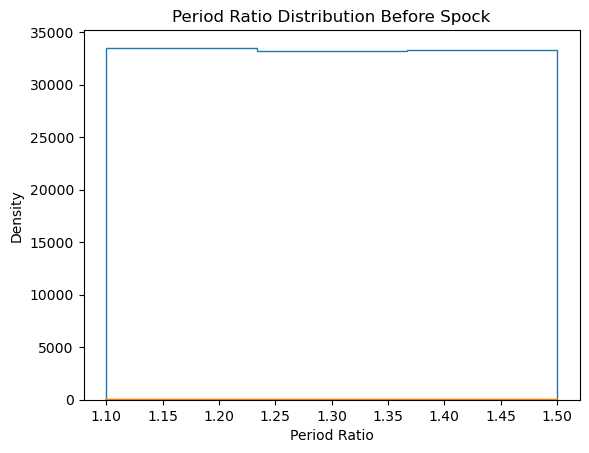

In [303]:
# Initialize uniform period ratio distribution
num_iter = 100000
p_min = 1.1
p_max = 1.5
p_list = []
for i in range(num_iter):
    #Generate p_ratio
    p = np.random.uniform(p_min,p_max)
    p_list.append(p)
    
    
density = stats.gaussian_kde(p_list)
n, x, _ = plt.hist(p_list, bins=np.linspace(1.1,1.5, 4),
                   histtype=u'step', density = False)
plt.plot(x, density(x))
plt.title("Period Ratio Distribution Before Spock")
plt.xlabel("Period Ratio")
plt.ylabel("Density")
plt.show()

# How to replicate data with SPOCK
We want to replicate the period ratio data using SPOCK. In order to do this, we start off by setting a range of eccentricities, masses, and period ratios to choose from. Based on KDE from observational data, there is different probabilities of obtaining certain parameters.

We generate simulations and determine their probability of surviving. We want to replicate the same number of systems observed with compact period ratios (99), so we generate 50 systems (2 period ratios each). We choose to use a system by generating a random number from 0 to 1, and if that number is less than the probability of the simulated system surviving, we use that system. Ex: If a simulated system has a 80% chance of surviving, there is an 80% chance that the random number will be under it, and we use it for a system that exists in our simulated world. 

In [ ]:
#waldo code
def simulate_trios(D):
    p1period = 1
    p2period = np.random.uniform(1.1,1.5)
    p3period = 0
    while p3period < p2period:
        s12= math.log10(p2period/p1period) 
        s23= np.random.normal(s12,D*s12)
        print(s12, D*s12, s23)
        p3period = p2period*10**s23
    return [p1period,p2period,p3period]


# trioslist=[simulate_trios(.302449556680029) for i in range(0,1000)]

In [318]:
# saving pvalues for each trial
trials_pvalue_mean = []


In [319]:
from tqdm import tqdm 

# this saves lists of lists so we can save each from each ecc change
ecc_cumsum = []
ecc_final_pratios = [] 
ecc_pvalue = []
ecc_final_stability = []
ecc_final_simulations = []
ecc_final_all_pratios = []
ecc_final_bad_pratios = []
ecc_final_periods = []
ecc_inner_pratios = []
ecc_outer_pratios = []


eccentricity_changing= [1]
#[.5,.6,.7,.8,.9,1,1.1,1.2,1.3,1.4,1.5] # changing ecc

# multiple trials to take an average CHANGE
num_experiments = 50





for a in range(len(eccentricity_changing)):
    print('ECCENTRICITY ' + str(a+1)+'/5')
    
    #This initializes the lists that populations can be added into
    trials_cumsum = []
    trials_final_pratios = [] 
    trials_pvalue = []
    trials_final_stability = []
    trials_final_simulations = []
    trials_final_bad_pratios = []
    trials_final_all_pratios = []
    trials_final_periods = []
    trials_inner_pratios = []
    trials_outer_pratios = []
    
    
    for q in tqdm(range(num_experiments)):
#         if q % 20 == 0:
#             print(str(q+1)+'/'+str(num_experiments)) # print how many exp run every 20 exp
        spock_e_list = [] # final eccentricities of planets
        spock_p_list = [] # final period ratios of planets
        all_pratios = []
        bad_p_list = []
        spock_m_list = [] # final masses of planets
        final_stability = [] # final probabilities of each simulated system being stable
        final_simulations = [] # final simulations used
        inner_pratios = []
        outer_pratios = []
        final_periods = []
        #CHANGE
        while len(all_pratios) < 161: # run until we get to 161 "simulated observations"
            #Get eccentricity and mass randomly
            #We're are testing a single system of 3 planets
            i = int(np.random.uniform(0,10000))
            temp_e1 = e_list[3*i] # choose random eccentricity, is there a reason why this is how it's randomly chosen
            temp_e2 = e_list[3*i+1]
            temp_e3 = e_list[3*i+2]
            temp_m1 = m_list[3*i] 
            temp_m2 = m_list[3*i+1] 
            temp_m3 = m_list[3*i+2] 
            # Get periods based on pearson r requirement and period distribution. 
            #Initialize to base values
            base_period = 1  #PLay with this value based on observed periods, but might not matter
            #.44 pearson r?
            stdev = dispersion(trios=get_trios(Plist = plist))[0] # dispersion #0.1161#0.1161 #This standard deviation sets the pearson r change by 50%
            pratio1 = p_list[int(np.random.uniform(0,num_iter))] # choose a ratio between planet, choose from array of random period ratios between 1.1-1.5
            pratio2_log = np.random.normal(pratio1,stdev*pratio1) #Use random.normal to imitate pearson r - tune stdev to desired pearson r
            pratio2 = 10**pratio2_log
            #Set the periods based on period ratios and base period
            # period1,p2,p3 = simpratios()
            period_1 = base_period
            period_2 = period_1 * pratio1
            period_3 = period_2 * pratio2

            # Making the 3planet temporary simulation
            temp_sim = rebound.Simulation()
            temp_sim.add(m=1) #Can possibly change mass of star, but might not matter
            temp_sim.add(m=temp_m1*mass_ratio, P = period_1, e = temp_e1)
            temp_sim.add(m=temp_m2*mass_ratio, P = period_2, e = temp_e2)
            temp_sim.add(m=temp_m3*mass_ratio, P = period_3, e = temp_e3)



            # Test stability of the temporary simulation
            temp_stability = fmodel.predict_stable(temp_sim)# get its spock probability for both groups of planets inner/outer

            # sets simulation stability to 0 if orbits cross
            if check_crossing(temp_sim):
                temp_stability = 0

            r = np.random.random() # this generates a random number from 0-1
            if r < temp_stability: # condition will trigger temp_stability% of the time
                final_simulations.append(temp_sim) # append simulation to our list of "simulated observations" that survived
                spock_p_list.append(pratio1)
                if (pratio2 > 1.1 and pratio2 < 1.5): #between constraints for small p ratio
                    spock_p_list.append(pratio2)
                else:
                    bad_p_list.append(pratio2)
                inner_pratios.append(pratio1)
                outer_pratios.append(pratio2)
                all_pratios.append(pratio1)
                all_pratios.append(pratio2)
                spock_e_list.append(temp_e1)
                spock_e_list.append(temp_e2)
                if (pratio2 > 1.1 and pratio2 < 1.5):
                    spock_e_list.append(temp_e3) #????? do i need this eccentr
                spock_m_list.append(temp_m1)
                spock_m_list.append(temp_m2)
                spock_m_list.append(temp_m3)
                final_stability.append(temp_stability) # append stability probability to list of stabilities that survived
                final_periods.append([period_1,period_2,period_3]) #trios!

            else:
                pass # simulated observation was unsuccessful. Continue to making a new system and repeat

        # make cdf in spock_p_cumsum
        spock_p_values, spock_p_base = np.histogram(spock_p_list, bins=np.linspace(1.1, 1.51, bin_number))
        spock_p_cumsum = np.cumsum(spock_p_values)/max(np.cumsum(spock_p_values)) #cdf!!!

        # ks test
        ksprob = scipy.stats.kstest(np.array(spock_p_list), np.array(pratios_observed), args=(), alternative='two-sided', method='exact')       
        pvalue = ksprob[1]

        # SAVE DATA FROM EACH TRIAL
        trials_pvalue.append(pvalue)
        trials_final_stability.append(final_stability) # list of stability arrays for each trial
        trials_final_pratios.append(spock_p_list) # list of period ratios for each trial
        trials_final_all_pratios.append(all_pratios)
        trials_final_bad_pratios.append(bad_p_list)
        trials_inner_pratios.append(inner_pratios)
        trials_outer_pratios.append(outer_pratios)
        trials_cumsum.append(spock_p_cumsum) # list of all cdfs corresponding to the period ratios 
        trials_final_simulations.append(final_simulations)
        trials_final_periods.append(final_periods)
    
    ecc_pvalue.append(trials_pvalue)
    ecc_final_stability.append(trials_final_stability) # list of stability arrays for each trial
    ecc_final_pratios.append(trials_final_pratios) # list of period ratios for each trial
    ecc_final_all_pratios.append(trials_final_all_pratios)
    ecc_final_bad_pratios.append(trials_final_bad_pratios)
    ecc_cumsum.append(trials_cumsum) # list of all cdfs corresponding to the period ratios 
    ecc_final_simulations.append(trials_final_simulations)
    ecc_final_periods.append(trials_final_periods)
    ecc_inner_pratios.append(trials_inner_pratios)
    ecc_outer_pratios.append(trials_outer_pratios)
    
    trials_pvalue_mean.append(np.asarray(trials_pvalue).mean())

ECCENTRICITY 1/5


100%|███████████████████████████████████████████████████████| 50/50 [1:24:52<00:00, 101.84s/it]


In [323]:
dispersion(trios=final_periods)

(0.21168938160257214, 0.008411977107174621)

In [320]:
# .5, .75, 1, 1.25, 1.5 slides 99 stdv
#trials_pvalue_mean.append(np.asarray(trials_pvalue).mean())
# trials_pvalue_mean.append(np.asarray(trials_pvalue).mean())
trials_pvalue_mean
# spock_p_list
# print(len(bad_p_list
#          ))
# bad_p_list

# #np.all(p_list < 1.5)
# np.random.uniform(p_min,p_max)

[0.031423939176743285]

([<matplotlib.axis.XTick at 0x7f9b3b8b9570>,
 [Text(0.5, 0, '0.5'),
  Text(0.6, 0, '0.6'),
  Text(0.7, 0, '0.7'),
  Text(0.8, 0, '0.8'),
  Text(0.9, 0, '0.9'),
  Text(1.0, 0, '1.0'),
  Text(1.1, 0, '1.1'),
  Text(1.2, 0, '1.2'),
  Text(1.3, 0, '1.3'),
  Text(1.4, 0, '1.4'),
  Text(1.5, 0, '1.5')])

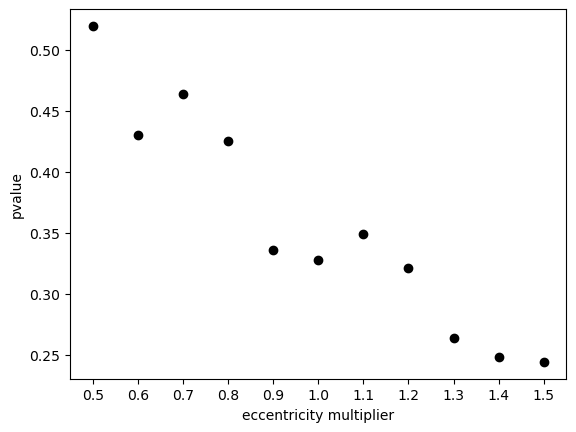

In [19]:
plt.plot([.5,.6,.7,.8,.9,1,1.1,1.2,1.3,1.4,1.5], trials_pvalue_mean, 'ko')
plt.ylabel("pvalue")
plt.xlabel('eccentricity multiplier')
plt.xticks([.5,.6,.7,.8,.9,1,1.1,1.2,1.3,1.4,1.5])

In [52]:
import statistics
statistics.stdev(ecc_pvalue[0])
print(min(ecc_pvalue[10]))
print(max(ecc_pvalue[10]))

0.002306872679744277
0.8052108861942998


# PDFs

Text(0.5, 0, 'period ratios')

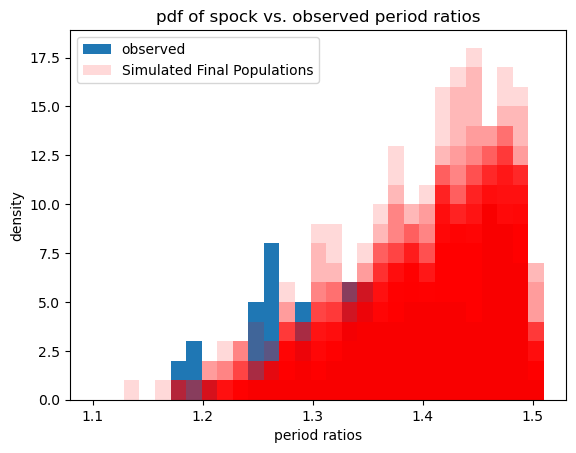

In [321]:
plt.title("pdf of spock vs. observed period ratios")
plt.hist(pratios_observed, bins=np.linspace(1.1, 1.51, bin_number), color="tab:blue", label = "observed")
for q in range(num_experiments):
    spock_p_list = trials_final_pratios[q]
    if q == 0: # add label to legend
        plt.hist(spock_p_list, bins=np.linspace(1.1, 1.51, bin_number), alpha=.15, color="red", label='Simulated Final Populations')
    else:
        plt.hist(spock_p_list, bins=np.linspace(1.1, 1.51, bin_number), alpha=.15, color="red")
plt.legend()
plt.ylabel("density")
plt.xlabel("period ratios")

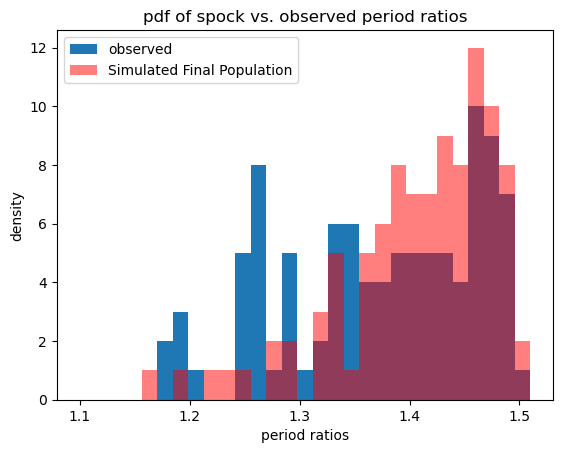

In [18]:
plt.title("pdf of spock vs. observed period ratios")
plt.hist(pratios_observed, bins=np.linspace(1.1, 1.51, bin_number), color="tab:blue", label = "observed")
plt.hist(spock_p_list, bins=np.linspace(1.1, 1.51, bin_number), alpha=.5, color="red", label='Simulated Final Population')
plt.ylabel("density")
plt.xlabel("period ratios")
plt.legend()

# CDFs

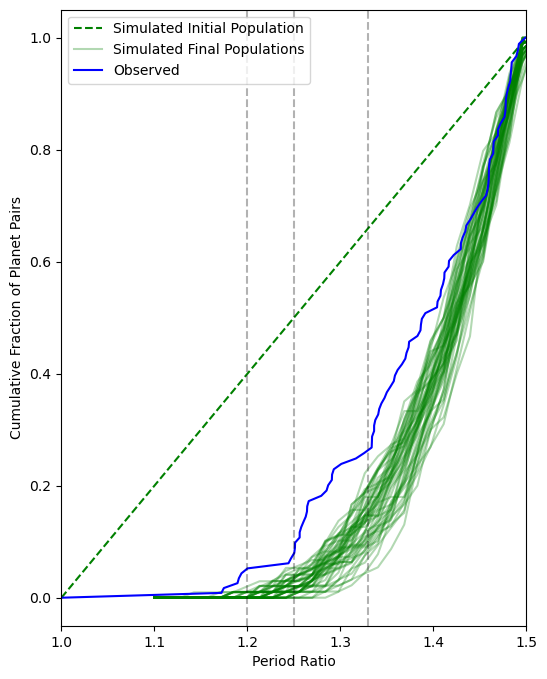

In [322]:
#Below we generate the plots for our population
#plt.style.use('./paper.mplstyle')
fig, ax = plt.subplots(figsize=(6,8))

ax.plot([1,1.5], [0,1], 'g--', label='Simulated Initial Population')
for q in range(num_experiments):
    spock_p_cumsum = trials_cumsum[q] #diff cumsum each time
    if q == 0:
        ax.plot(spock_p_base, [0]+list(spock_p_cumsum), c = 'green', alpha = 0.3, label='Simulated Final Populations')
    else:
        ax.plot(spock_p_base, [0]+list(spock_p_cumsum), c = 'green', alpha = 0.3)
ax.plot([1] + list(sorted(pratios_observed)), [0]+list(observed_period_cdf), c = 'blue', label='Observed')
ax.axvline(1.2, color='black', linestyle='--', alpha=0.3)
ax.axvline(1.25, color='black', linestyle='--', alpha=0.3)
ax.axvline(1.33, color='black', linestyle='--', alpha=0.3)
ax.legend()
ax.set_xlabel("Period Ratio")
ax.set_ylabel("Cumulative Fraction of Planet Pairs")
ax.set_xlim([1.,1.5])
fig.savefig('inneredge.pdf', bbox_inches='tight')

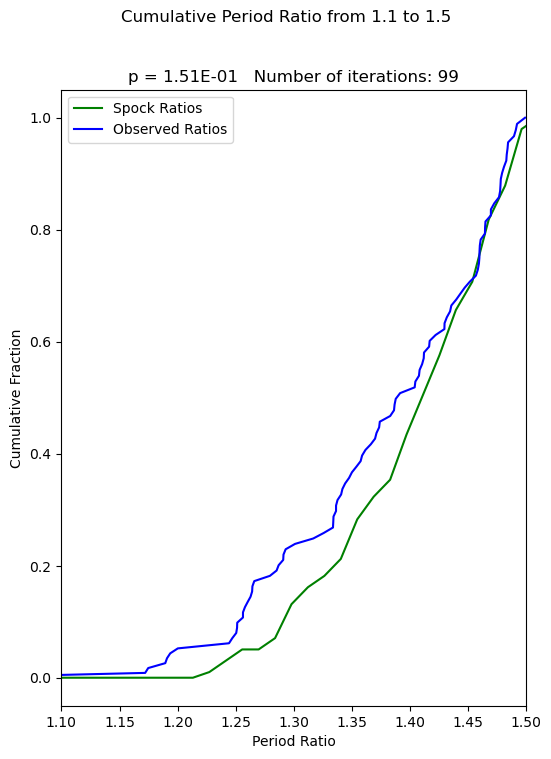

<Figure size 1000x100 with 0 Axes>

In [35]:
fig = plt.figure()
fig.set_figheight(8)
fig.set_figwidth(6)

plt.plot(spock_p_base, [0]+list(spock_p_cumsum), c = 'green')
plt.plot([1] + list(pratios_observed), [0]+list(observed_period_cdf), c = 'blue')
plt.legend(["Spock Ratios", "Observed Ratios"])
plt.suptitle("Cumulative Period Ratio from 1.1 to 1.5")
plt.title("p = " + '%.2E' % Decimal( str(trials_pvalue[-1])  ) + "   Number of iterations: " + str(len(spock_p_list)))
plt.xlabel("Period Ratio")
plt.ylabel("Cumulative Fraction")
plt.xlim(1.1,1.5)
plt.figure(figsize=(10, 1))
plt.show()

# KDEs with SPOCK

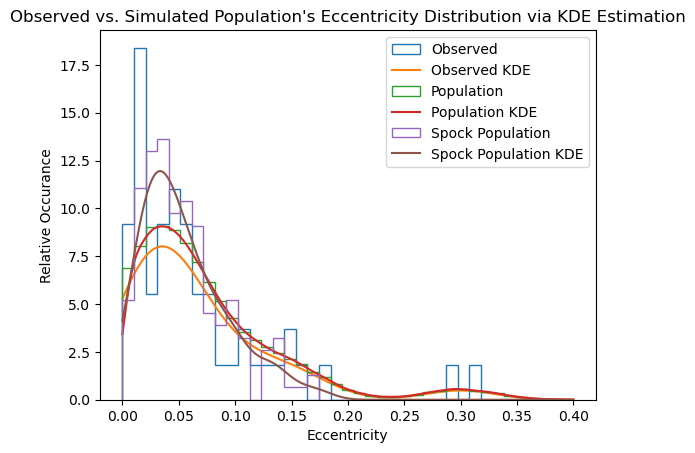

In [35]:
# Create a histogram of the original data
n, bins_e, patches = plt.hist(eccentricity, bins=np.linspace(0, 0.4, 40), histtype='step', density=True, label = 'Observed')

# Plot the kernel density curve of the original data
plt.plot(x_grid_e, kde_e(x_grid_e), label='Observed KDE')

# Create a histogram of the new samples
n_new, bins_new, patches_new = plt.hist(e_list, bins=bins_e, histtype='step', density=True, label = 'Population')

# Plot the kernel density curve of the new samples, e_list spock selected from
kde_new_e = gaussian_kde(e_list)
plt.plot(x_grid_e, kde_new_e(x_grid_e), label='Population KDE')

#plot the actual eccentricities spock took
n_s_new, bins_s_new, patches_s_new = plt.hist(spock_e_list, bins=bins_e, histtype='step', density=True, label = 'Spock Population')
kde_s_new = gaussian_kde(spock_e_list)
plt.plot(x_grid_e, kde_s_new(x_grid_e), label='Spock Population KDE')


# Set plot title, labels, and legend
plt.title("Observed vs. Simulated Population's Eccentricity Distribution via KDE Estimation")
plt.xlabel("Eccentricity")
plt.ylabel("Relative Occurance")
plt.legend()

# Show the plot
plt.show()

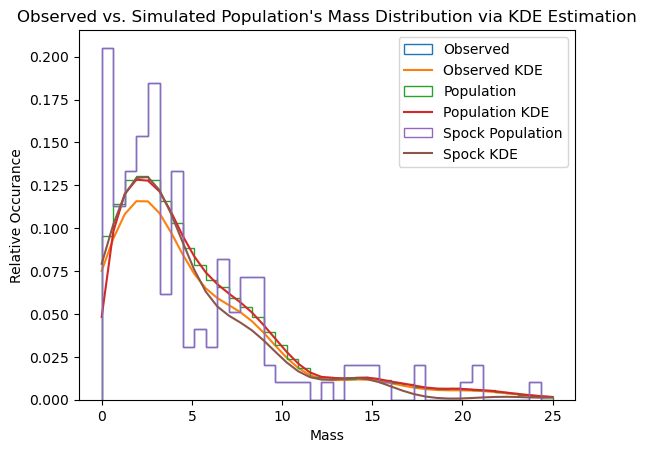

In [188]:
#masses after spock
# Create a histogram of the original data
n, bins, patches = plt.hist(mass, bins=np.linspace(0, 25, 40), histtype='step', density=True, label = 'Observed')

# Plot the kernel density curve of the original data
plt.plot(x_grid, kde(x_grid), label='Observed KDE')

# Create a histogram of the new samples, m_list spock selected from
n_new, bins_new, patches_new = plt.hist(m_list, bins=bins, histtype='step', density=True, label = 'Population')

# Plot the kernel density curve of the new samples
kde_new = gaussian_kde(m_list)
plt.plot(x_grid, kde_new(x_grid), label='Population KDE')

#plot spock mass distribution
ns, binss, patchess = plt.hist(mass, bins=np.linspace(0, 25, 40), histtype='step', density=True, label = 'Spock Population')
kdes=gaussian_kde(spock_m_list)
plt.plot(x_grid, kdes(x_grid), label='Spock KDE')

# Set plot title, labels, and legend
plt.title("Observed vs. Simulated Population's Mass Distribution via KDE Estimation")
plt.xlabel("Mass")
plt.ylabel("Relative Occurance")
plt.legend()


# Show the plot
plt.show()